In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap

# Decomposition

### DeepLoc

Language model

In [10]:
root = '../data/DeepLoc/'
f_names = [
    'DeepLocEmbedd_BERT_BFD.csv',
    'DeepLocEmbedd_Albert_BFD.csv',
    'DeepLocEmbedd_T5_BFD.csv',
    'DeepLocEmbedd_T5_FT.csv'
    ]

# load dataset
dfs = [pd.read_csv(os.path.join(root, f_name)) for f_name in f_names]
# df = pd.read_csv(os.path.join(root, f_names[1]))

# processing
M_idx = dfs[0].iloc[:,1]=='M'
S_idx = dfs[0].iloc[:,1]=='S'
localization = ['M']*sum(M_idx) + ['S']*sum(S_idx)
XLM = [np.array(pd.concat([df[M_idx], df[S_idx]], axis=0).iloc[:,2:]) for df in dfs]
localization_idxes = [np.where(np.array(localization)==loc) for loc in list(set(localization))]

Descriptor

In [11]:
f_names = [
    'DeepLocDescriptorAAindex.csv',
    'DeepLocDescriptorAutocorrelation.csv',
    ]
dfs = [pd.read_csv(os.path.join(root, f_name)) for f_name in f_names]
XD = [np.array(pd.concat([df[M_idx], df[S_idx]], axis=0).iloc[:,3:].fillna(0)) for df in dfs]
# [np.array(df.iloc[:,3:].fillna(0)) for df in dfs]

 PCA

In [12]:
pcs, evrs = [], []
for X in XLM+XD:
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    X_scal = scaler.fit_transform(X)
    X_pca = pca.fit_transform(X_scal)
    evr = pca.explained_variance_ratio_
    pcs.append(X_pca)
    evrs.append(evr)

In [ ]:
['Membrane', 'Soluable']

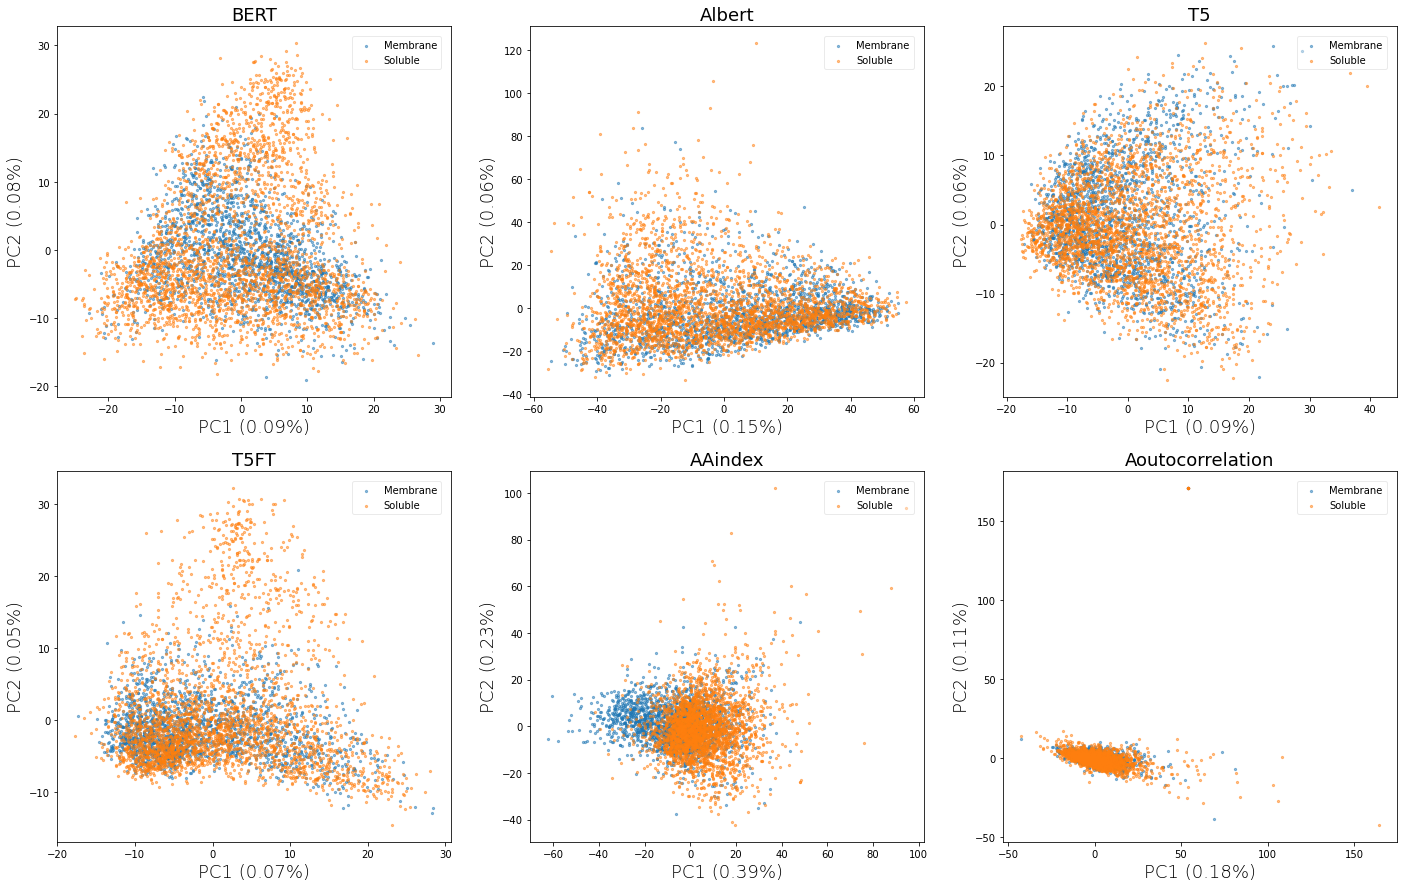

In [16]:
names = ['BERT', 'Albert', 'T5', 'T5FT', 'AAindex', 'Aoutocorrelation']

fig, axs = plt.subplots(2,3,figsize=(24,15))
for i in range(len(pcs)):
    if i < 3:
        ax1, ax2 = 0, i
    else:
        ax1, ax2 = 1, i-3
    for loc, idx in zip(['Membrane', 'Soluble'], localization_idxes):
        axs[ax1, ax2].scatter(
                pcs[i][idx,0],
                pcs[i][idx,1],
                s=5,
                alpha=0.5,
                label=loc,
            )
        axs[ax1, ax2].set_xlabel(f'PC1 ({round(evrs[i][0], 2)}%)', fontsize=18, fontweight=20)
        axs[ax1, ax2].set_ylabel(f'PC2 ({round(evrs[i][1], 2)}%)', fontsize=18, fontweight=20)
        axs[ax1, ax2].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1).get_frame().set_alpha(0.4)
        axs[ax1, ax2].set_title(names[i], fontsize=18)
fig.savefig('../results/20220706_DeepLocMS_PCA.png', dpi=200)

UMAP

In [17]:
embeddings = []
for X in tqdm(XLM+XD):
    scaler = StandardScaler()
    X_scal = scaler.fit_transform(X)
    mapper = umap.UMAP(random_state=0)
    embedding = mapper.fit_transform(X_scal)
    embeddings.append(embedding)

100%|██████████| 6/6 [01:26<00:00, 14.47s/it]


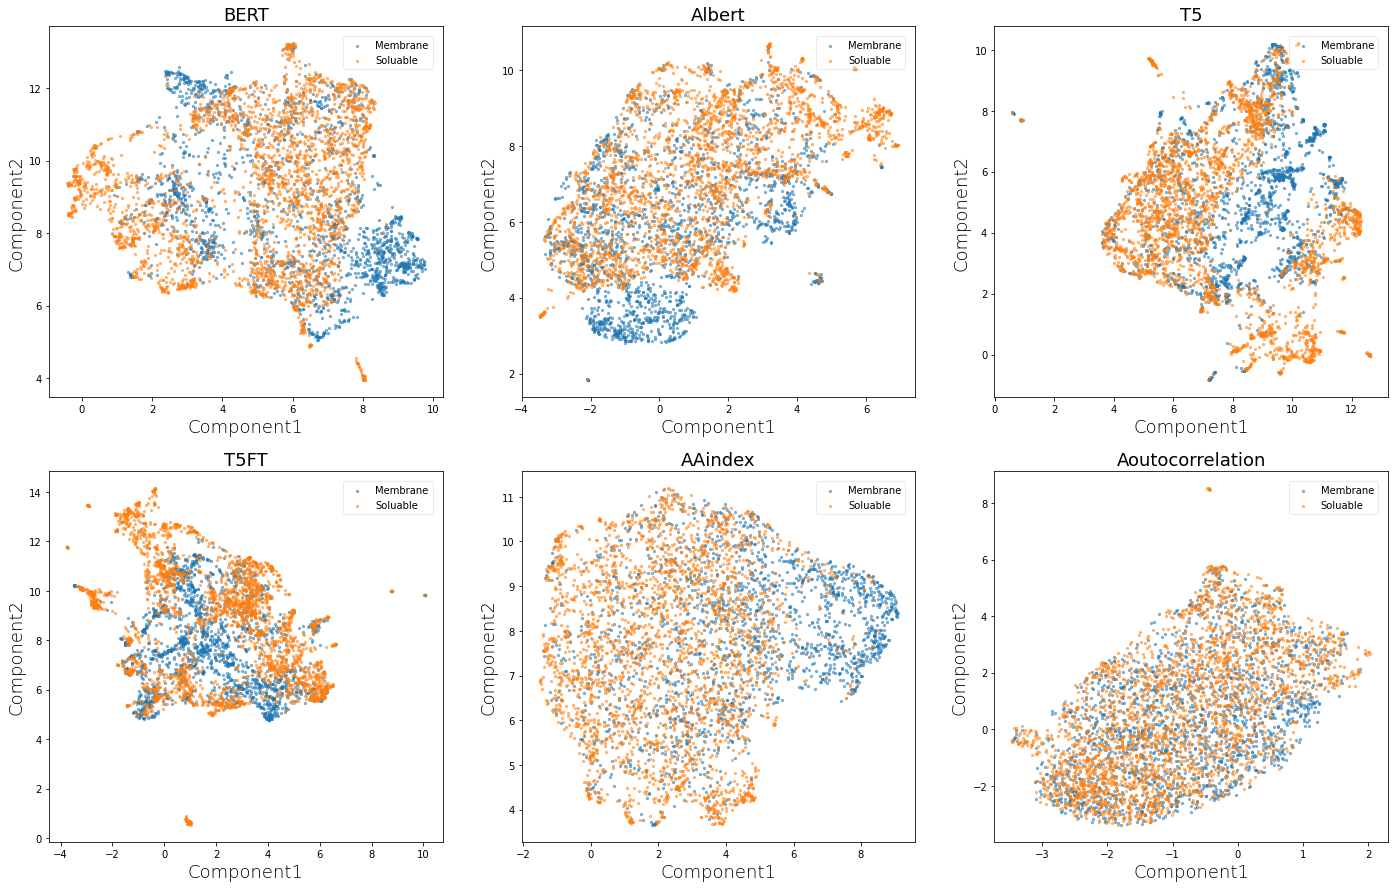

In [20]:
names = ['BERT', 'Albert', 'T5', 'T5FT', 'AAindex', 'Aoutocorrelation']

fig, axs = plt.subplots(2,3,figsize=(24,15))
for i in range(len(embeddings)):
    if i < 3:
        ax1, ax2 = 0, i
    else:
        ax1, ax2 = 1, i-3
    for loc, idx in zip(['Membrane', 'Soluable'], localization_idxes):
        axs[ax1, ax2].scatter(
                embeddings[i][idx,0],
                embeddings[i][idx,1],
                s=5,
                alpha=0.5,
                label=loc,
            )
        axs[ax1, ax2].set_xlabel('Component1', fontsize=18, fontweight=20)
        axs[ax1, ax2].set_ylabel('Component2', fontsize=18, fontweight=20)
        axs[ax1, ax2].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1).get_frame().set_alpha(0.4)    
        axs[ax1, ax2].set_title(names[i], fontsize=18)
fig.savefig('../results/20220706_DeepLocMS_UMAP.png', dpi=200)